In [2]:
import pandas as pd
print('Pandas version is %s' % pd.__version__)
import numpy as np
print('NumPy version is %s' % np.__version__)
import statsmodels.api as sm
from statsmodels.robust.scale import mad as mad_function
print('Statsmodels version is %s' % sm.__version__)
import scipy.stats as stats

import matplotlib
import matplotlib.pyplot as plt
print('Matplotlib version is %s' % matplotlib.__version__)
import seaborn as sns
print('Seaborn version is %s' % sns.__version__)
%matplotlib inline
%pylab inline

import time
import random
import itertools
print('Imports done.')


Pandas version is 1.2.3
NumPy version is 1.20.1
Statsmodels version is 0.13.2
Matplotlib version is 3.3.4
Seaborn version is 0.11.1
Populating the interactive namespace from numpy and matplotlib
Imports done.


# Reading in and cleaning up the data

In [53]:
### Read in data ###
data_mr_young = pd.read_excel('miniTRK_APS_Recognition_Trial-by-Trial_Data.xlsx')
indeces = data_mr_young[data_mr_young['Correct'] == -1].index  # -1 in 'Correct' column denotes missing response
data_mr_young = data_mr_young.drop(indeces, axis=0)

data_online = pd.read_excel('longTRK_APS_Recognition_Trial-by-Trial_Data.xlsx')
data_online.rename(columns={'Online ID':'online ID'}, inplace=True) # Renaming for consistency

# Splitting young and old online data
data_online_young = data_online[data_online['Group']==1]
data_online_old = data_online[data_online['Group']==0]
data_online_old = data_online_old.replace("410O824F)", "410O824F")
data_list = [data_mr_young, data_online_young, data_online_old, data_online]
data_names = ['data_mr_young', 'data_online_young', 'data_online_old', 'data_online']
display(data_online.head(), data_mr_young.head())


,online ID,Group,TrialIndex,TrialType,StimType,EncodingStimType,rec_trial_key.keys,rec_trial_key.rt,CurrentImage,EncodingImage,...,TripletMemberB,TripletMemberC,CurrentX,CurrentY,Xcoordinate,Ycoordinate,Xcoordinate_lure1,Ycoordinate_lure1,Correct,ResponseNew
0,908O1823F,0,1,OBJ,FOIL,FOIL,j,2.7586,stimuli/fractals/59c.jpg,NaN,...,NaN,NaN,0.304695,0.379784,NaN,NaN,NaN,NaN,1,1
1,908O1823F,0,2,OBJ,LURE,ERP,f,1.4135,stimuli/fractals/163c.jpg,stimuli/fractals/163b.jpg,...,stimuli/fractals/163a.jpg,stimuli/fractals/163c.jpg,0.376897,0.051308,0.376897,0.051308,0.182213,-0.364402,0,0
2,908O1823F,0,3,OBJ,TARGET,ERP,j,2.3935,stimuli/fractals/119b.jpg,stimuli/fractals/119b.jpg,...,stimuli/fractals/119c.jpg,stimuli/fractals/119a.jpg,-0.205913,0.156378,-0.205913,0.156378,-0.361948,-0.338631,0,1
3,908O1823F,0,4,OBJ,LURE,ERP,f,1.7771,stimuli/fractals/147a.jpg,stimuli/fractals/147b.jpg,...,stimuli/fractals/147c.jpg,stimuli/fractals/147a.jpg,-0.380412,-0.034671,-0.380412,-0.034671,-0.125804,-0.194251,0,0
4,908O1823F,0,5,OBJ,FOIL,FOIL,f,3.4714,stimuli/fractals/161c.jpg,NaN,...,NaN,NaN,0.109361,0.393758,NaN,NaN,NaN,NaN,0,0


,online ID,MR ID,Stimuli Table,TrialIndex,TrialType,StimType,EncodingStimType,rec_trial_key.keys,rec_trial_key.rt,CurrentImage,...,TRUE_RGB2_BIN,TRUE_RATING2_BIN,DIST1,DIST1_BIN,DIST2,DIST2_BIN,TRUE_DIST2,TRUE_DIST2_BIN,Correct,ResponseNew
0,101mTRK21M,275592,2,1,OBJ,FOIL,FOIL,c,1.356678,stimuli/fractals/153a.jpg,...,foil,foil,3.026812e+02,3,302.681192,3,3.026812e+02,3,1,1
1,101mTRK21M,275592,2,2,OBJ,LURE,ERP,b,1.532706,stimuli/fractals/25b.jpg,...,medium,high,0.000000e+00,0,292.101183,2,0.000000e+00,0,0,0
2,101mTRK21M,275592,2,3,OBJ,TARGET,ERP,c,1.720454,stimuli/fractals/62c.jpg,...,target,target,2.842171e-14,0,306.414435,3,2.842171e-14,0,0,1
3,101mTRK21M,275592,2,4,OBJ,LURE,ERP,b,1.995551,stimuli/fractals/73b.jpg,...,high,medium,5.684342e-14,0,259.168591,2,5.684342e-14,0,0,0
4,101mTRK21M,275592,2,5,OBJ,FOIL,FOIL,c,1.295759,stimuli/fractals/108c.jpg,...,foil,foil,4.308871e+02,4,430.887072,4,4.308871e+02,4,1,1


In [21]:
for data, data_name in zip(data_list, data_names):
    participants = data['online ID'].unique()
    print(data_name, ": ", len(participants), " participants")

# for data, data_name in zip(data_list, data_names):
#     participants = data['online ID'].unique()
#     print(data_name, ": ", participants)

data_mr_young :  42  participants
data_online_young :  48  participants
data_online_old :  91  participants
data_online :  139  participants


In [65]:
# MR data demographics
participants_data = pd.read_csv("G:\My Drive\Research stuff\MA szakdoga\demographics\miniTerKepEsz_Participants.csv")
mr_participants = participants_data[participants_data['Online ID'].isin(data_mr_young['online ID'].unique())]

mr_young_names = data_mr_young['online ID'].unique()
mr_demograph_names = participants_data['Online ID'].unique()
overlap = [name for name in mr_young_names if name in mr_demograph_names]
just_mr_young_names = [name for name in mr_young_names if name not in mr_demograph_names]

print("MR data demographics")
print("Missing demographic data: ", len(just_mr_young_names))
print(mr_participants['Gender'].value_counts())
print("Mean age = ", np.round(np.mean(mr_participants['Age']), 2), ", SD=", np.round(np.std(mr_participants['Age']),2))
print("-"*40)

# Online data demopgraphics
old_dem = pd.read_csv("G:\My Drive\Research stuff\MA szakdoga\demographics\longTerKepEsz_Participants_old.csv")
young_dem = pd.read_csv("G:\My Drive\Research stuff\MA szakdoga\demographics\longTerKepEsz_Participants_young.csv")

online_old_dem = old_dem[old_dem['online ID'].isin(data_online_old['online ID'].unique())]
online_young_dem = young_dem[young_dem['online ID'].isin(data_online_young['online ID'].unique())]

online_old_dem_names = online_old_dem['online ID'].unique()
online_young_dem_names = online_young_dem['online ID'].unique()

just_online_old_dem_names = [name for name in data_online_old['online ID'].unique() if name not in online_old_dem_names]
just_online_young_dem_names = [name for name in data_online_young['online ID'].unique() if name not in online_young_dem_names]

print("Online data demographics")
print("Missing demographic data (old): ", len(just_online_old_dem_names), just_online_old_dem_names)
print(online_old_dem['Gender'].value_counts())
print("Mean age = ", np.round(np.mean(online_old_dem['Age'].astype(int)), 2), ", SD=", np.round(np.std(online_old_dem['Age'].astype(int)),2))
print("Missing demographic data (young): ", len(just_online_young_dem_names))
print(online_young_dem['Gender'].value_counts())
print("Mean age = ", np.round(np.mean(online_young_dem['Age']), 2), ", SD=", np.round(np.std(online_young_dem['Age']),2))

display(online_old_dem[online_old_dem['online ID']=='134O272F'])

MR data demographics
Missing demographic data:  0
Female    21
Male      21
Name: Gender, dtype: int64
Mean age =  22.57 , SD= 2.26
----------------------------------------
Online data demographics
Missing demographic data (old):  36 [' 908O1823F', '10832170F', '1124O2252F-2', '1150234F', '120902422F', '214432M', '2150434F', '227O458F-2', '2320468F', '2480500F', '2550514F', '2920588F', '3870778F', '4370878F', '4470898F', '4560916F', '4870978M', '50501014M', '509O122F', '585O1174F', '59201188F', '6060I216F', '61101226F', '61401232F', '63201268M', '63701278F', '65701318M', '658O1320', '66701338F', '74301490F', '77501554M', '80501614M', '81901642F', '84501694F', '86401732M-2', '95601916M-2']
Female     32
Male       21
Female      1
Name: Gender, dtype: int64
Mean age =  69.85 , SD= 4.12
Missing demographic data (young):  0
Female    40
Male       8
Name: Gender, dtype: int64
Mean age =  23.83 , SD= 2.66


,online ID,Contact person,Age,Gender,MR saftey,Study Type,Online Invitation Sent (date),Information and Notes,Online MoCA (date),MoCA notes,...,Full study with Moca,Online Study with Moca,Males in Full Study with Debriefing,Males in Online study with Debriefing,Unnamed: 40,Unnamed: 41,Unnamed: 42,Unnamed: 43,Unnamed: 44,Unnamed: 45


In [3]:
### Functions for preprocessing ###

def filter_completed(data, criteria=None, id_var='online ID'):
    """
    Filter out participants having less completed trials than criterion. Print number of deleted participants.

    Parameters
    ----------
    data: dataframe
    criteria: float or None
        Minimum number of trials for a participant to be included
    id_var: str
        Name of column containing participant names

    Returns
    -------
    dataframe
        Filtered data

    """
    participant_completed = [name for name in data[id_var].unique() if (data[data[id_var]==name][id_var].value_counts() >= criteria).all()]
    difference = len(data[id_var].unique()) - len(participant_completed)
    print('Deleted participants:', difference)

    data = data[data[id_var].isin(participant_completed)]

    return data


def filter_outliers(data, var_name='rec_trial_key.rt', mode='filter'):
    """
    Filtering outlier trials using the MAD-median rule (Leys et al., 2013, https://doi.org/10.1016/j.jesp.2013.03.013)

    Parameters
    ----------
    data: dataframe
    var_name: str
        Name of column to calculate outliers on
    mode: {'filter', 'add'}
        Filters out outlier trials if set to 'filter'. Adds 'outlier' column to dataframe if set to 'add', where 1 signifies an outlier.

    Returns
    -------
    dataframe
        Filtered dataframe
    """
    median = np.median(data[var_name].dropna())
    mad_value = mad_function(data[var_name].dropna())
    lower_limit = median - 2.5 * mad_value
    upper_limit = median + 2.5 * mad_value
    data_og_len = len(data)
    if mode == 'filter':
        data = data[(data[var_name]>lower_limit)&(data[var_name]<upper_limit)]
        data_filtered_len = len(data)
        # print("Filtered outliers: ", data_og_len - data_filtered_len)
    elif mode == 'add':
        data['outlier'] = np.where((data[var_name]<lower_limit)|(data[var_name]>upper_limit), 1, 0)
    return data

The history saving thread hit an unexpected error (OperationalError('database or disk is full')).History will not be written to the database.


In [19]:
### Data preparation ###

# Filter out participants with more than 10% missing trials
for i in range(len(data_list)):
    data = data_list[i]
    data_list[i] = filter_completed(data, 144*0.9)

# Calculate new variables
window_size = 5
for i in range(len(data_list)):
    data = data_list[i]
    rollings = []
    trial_nums = []
    for participant in data['online ID'].unique():
        df_participant = data[data['online ID']==participant]
        participant_range = range(len(df_participant))
        trial_nums += [i for i in participant_range]
        windows = df_participant['rec_trial_key.rt'].rolling(window_size)
        rolling = windows.mean()
        rollings += list(rolling)
    data_list[i]['rolling_avg'] = rollings  # Rolling average RT
    data_list[i]['trial_num'] = trial_nums  # Trial number
    data_list[i] = filter_outliers(data_list[i], mode='add')  # Outlier

# Combined dataframe for plotting
for i in range(len(data_list)):
    df = data_list[i]
    df.loc[:,'data_set'] = data_names[i]
    data_list[i] = df
data_all = pd.concat([data_list[i] for i in range(len(data_list))])

# Plot RT distributions
# sns.displot(data=data_all, x='rec_trial_key.rt', hue='online ID', kind='kde', col='data_set', legend=False)

# Check completed trials
# for data, data_name in zip(data_list, data_names):
#     data_check = pd.pivot_table(data=data, index='online ID', columns='StimType', values='TrialIndex', aggfunc='count')
#     data_check_long = data_check.melt(ignore_index=False)
#     data_check_long.reset_index(inplace=True)

#     fig, ax = plt.subplots(figsize=(25,10))
#     fig.suptitle(data_name)
#     sns.barplot(data=data_check_long, x="online ID", y="value", hue="StimType", ax=ax)
#     plt.ylabel('trials')
#     plt.xticks(rotation=90)
#     plt.show()


Deleted participants: 0
Deleted participants: 1
Deleted participants: 9
Deleted participants: 10


<ipython-input-19-1a1b5bf3e8d9>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_list[i]['rolling_avg'] = rollings  # Rolling average RT
<ipython-input-19-1a1b5bf3e8d9>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_list[i]['trial_num'] = trial_nums  # Trial number
<ipython-input-18-8c82fcee4462>:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://p

In [20]:
# Save preprocessed data
for i in range(len(data_list)):
    data_list[i].to_csv(r"G:\My Drive\Research stuff\MA szakdoga\cleaned\%s.csv" % data_names[i])


# Calculating effect sizes

In [5]:
def edge_correction(proportion, all):
    """
    Perform edge-correction to avoid infinite values in d-prime calculations.

    Parameters
    ----------
    proportion : float
        Quantity to check.
    all: float
        Quantity to use in correction, e.g. hits + misses, false alarms + correct rejections, etc.

    Returns
    -------
    float
    
    """
    # TODO Edge correction on values greater than 1 / smaller then 0
    # Should we exclude participants instead?
    if proportion >= 1:
        proportion = 1 - (0.5/all)
    elif proportion <= 0:
        proportion = 0.5/all
    return proportion

def discrimination_calculator(data, id_var='online ID', stimtype_var='StimType', response_var='ResponseNew', method='difference', filters=None):
    """
    Compute d-prime as a measure of discrimination in the APS task. D-prime is calculated as the difference in 
    the z-transformed proportions of 'old' answers to 'target' stimuli and 'old' answers to 'lure' stimuli.

    Parameters
    ----------
    data : dataframe
        Long format dataframe with a column for subject, stimulus type and response (new/old).
    id_var : str
        Name of column containing participant names.
    stimtype_var : str
        Name of column containing stimulus type in trial.
    response_var : str
        Name of column containing responses. 'New' should be coded as 1, 'old' should be coded as 0.
    method : {'regression', 'difference'}
        If 'regression', calculate d-prime from regression which allows including multiple regressors for noise filtering.
        If 'difference', calculate d-prime as in e.g. Loiotile & Courtney (2015) doi.org/10.1101/lm.038141.115
    filters : list of str
        List of regressors to include in d-prime calculation for noise filtering.

    Returns
    -------
    dataframe
        Dataframe containing a column for participant ID and a column for their respective d-prime values.
    
    """

    # TODO Is edge-correction the best solution to deal with infs?
    # Edge-correction: https://lindeloev.net/calculating-d-in-python-and-php/
    # adjusted ratios: https://github.com/neuropsychology/psycho.R/blob/master/R/dprime.R
    # or just returning nan.
    # TODO calculate standarized difference as a slope to be able to use regressors for noise-filtering

    discrimination_df = pd.DataFrame(columns=[id_var, 'd_prime', 'p_old_target', 'p_old_lure']) # Setup output dataframe
    for id in data[id_var].unique():
        # Looping through each participant's data
        data_participant = data[data[id_var]==id]
        all_target = len(data_participant[data_participant[stimtype_var]=='TARGET'])
        all_lure = len(data_participant[data_participant[stimtype_var]=='LURE'])
        
        if method == 'difference':
            # Calculate proportion of old-target answers to all answers and old-lure answers to all answers
            p_old_target = len(data_participant[(data_participant[response_var]==0) & (data_participant[stimtype_var]=='TARGET')]) / all_target
            p_old_lure = len(data_participant[(data_participant[response_var]==0) & (data_participant[stimtype_var]=='LURE')]) / all_lure
            
            # Avoiding infinite values by edge-correction
            p_old_target = edge_correction(p_old_target, all_target)
            p_old_lure = edge_correction(p_old_lure, all_lure)
            
        elif method == 'regression':
            # Calculate d-prime with regression
            data_target_lure = data_participant[(data_participant[stimtype_var]=='TARGET')|(data_participant[stimtype_var]=='LURE')]
            recode_dict = {'LURE':1, 'TARGET': 0}
            data_target_lure.loc[:,'StimTypeNum'] = [recode_dict[data_target_lure.loc[i, stimtype_var]] for i in data_target_lure.index]
            data_target_lure.loc[:, 'ResponseOld'] = abs(data_target_lure[response_var]-1)
            regressors = ['StimTypeNum'] + filters if filters else ['StimTypeNum']
            
            result = sm.regression.linear_model.OLS(data_target_lure['ResponseOld'].astype(float), sm.add_constant(data_target_lure[regressors])).fit()
            p_old_target, p_old_lure = edge_correction(result.params[0], all_target), edge_correction(result.params[0] + result.params[1], all_lure)
        
        discrimination = stats.norm.ppf(p_old_target) - stats.norm.ppf(p_old_lure)
        discrimination_df = discrimination_df.append({id_var:id, 'd_prime':discrimination, 'p_old_target':p_old_target,'p_old_lure':p_old_lure}, ignore_index=True)
    
    return discrimination_df


# Filtering

In [6]:
def filter(data, filters):
    """
    Filter trials according to filtering criteria in filters.

    Parameters
    ----------
    data: pandas dataframe
    filters: {'outliers', 'previous_error'}

    Returns
    -------
    pandas dataframe
    """
    og_len = len(data)
    if 'outliers' in filters:
        data = filter_outliers(data, var_name='rec_trial_key.rt')
    if 'previous_error' in filters:
        data.loc[:,'previous_correct'] = data['Correct'].shift(1)
        data = data[data['previous_correct'] == 1].copy()
    if (len(filters) == 1) & (filters[0]=='none'):
        print('No filtering')
    else:
        print('Filtered out {0} ({1}%) trials with {2}'.format(og_len-len(data), np.round((1-(len(data)/og_len)) * 100, 2), ', '.join(filters)))

    return data


# Even-odd split-half reliability with Spearman-Brown correction

In [28]:
def correl_ci(coefficient, CI, data):
    """
    Calculate confidence interval of correlation coefficient using Fisher's Z-transform.
    
    Paramters
    ----------
    coefficient: float
        The correlation coefficient.
    CI: {90, 95, 99}
        The desired confidence level.
    data: dataframe
        The dataframe from which the correlation coefficient was calculated.

    Returns
    -------
    list
        First element is the correlation coefficient, second element is the lower bound
        of the CI and the third element is the upper bound of the CI.
    
    """

    #CI transform
    if CI == 90:
        z_CI = 1.645
    elif CI == 95:
        z_CI = 1.96
    elif CI == 99:
        z_CI = 2.576
    
    #Calculate
    datan = len(data)
    z_r = 0.5 * np.log((1+coefficient) / (1-coefficient))
    z_low = z_r - z_CI * np.sqrt(1.0/(datan-3))
    z_high = z_r + z_CI * np.sqrt(1.0/(datan-3))
    
    #Convert back
    r_low = ((np.exp(2 * z_low)) - 1) / ((np.exp(2 * z_low)) + 1)
    r_high = ((np.exp(2 * z_high)) - 1) / ((np.exp(2 * z_high)) + 1)

    return [coefficient, r_low, r_high]

def split_var(length):
    """
    Make a list of given length of alternating 0s and 1s.

    Parameters
    ----------
    length: int
        Length of list
    
    Returns
    -------
    list

    """
    a = np.empty((length,))
    a[::2] = 1
    a[1::2] = 0
    return a.tolist()

def assign_even_odd(data, id_var):
    """
    Split data into even and odd trials for each participant.

    Parameters
    ----------
    data: dataframe
    id_var: string
        Name of the column holding participant names
    
    Returns
    -------
    dataframe
        The data containing even numbered trials
    dataframe
        The data containing odd numbered trials
    dataframe
        The original data
    """
    data_sorted = pd.DataFrame()
    for participant in data[id_var].unique():
        data_participant = data[data[id_var] == participant].sort_values('StimType')  # Stratified even-odd (Pronk, 2021)
        splitting_list = split_var(len(data_participant))
        data_participant.loc[:,'split_var'] = splitting_list
        data_sorted = pd.concat([data_sorted, data_participant])

    data_even = data_sorted[data_sorted['split_var']==0]
    data_odd = data_sorted[data_sorted['split_var']==1]

    return data_even, data_odd, data

def splithalf(data, id_var='online ID', nonparametric=False, method='regression', regressors=[]):
    """
    Calculate split-half reliability with and without Spearman-Brown correction.

    Parameters
    ----------
    data: dataframe
    id_var: str
        Name of the column holding participant names
    nonparametric: bool
        Calculate Spearman's rank-order correlation if True, Pearson's if False
    method: {'regression', 'difference}
        See discrimination_calculator for details.
    regressors: list of str
        See discrimination_calculator for details.

    Returns
    -------
    list
        First element is the uncorrected correlation coefficient, second element is the 
        lower bound of the CI and the third element is the upper bound of the CI.
    list
        First element is the Spearman-Brown corrected correlation coefficient, second element
        is the lower bound of the CI and the third element is the upper bound of the CI.
    list
        Difference as percentage of total trials of given type (TARGET and LURE respectively)
        between the two halves.
    """
    
    data_even, data_odd, data = assign_even_odd(data, id_var)
    even_target, odd_target, even_lure, odd_lure = len(data_even[data_even['StimType']=='TARGET']), len(data_odd[data_odd['StimType']=='TARGET']), len(data_even[data_even['StimType']=='LURE']), len(data_odd[data_odd['StimType']=='LURE'])
    target_diff, lure_diff = abs(even_target - odd_target) / len(data[data['StimType']=='TARGET']) *100, abs(even_lure - odd_lure) / len(data[data['StimType']=='TARGET']) * 100

    discrimination_even = discrimination_calculator(data_even, method=method, filters=regressors)
    discrimination_odd = discrimination_calculator(data_odd, method=method, filters=regressors)

    if nonparametric:
        r_raw = stats.spearmanr(discrimination_even['d_prime'], discrimination_odd['d_prime']).correlation
    else:
        r_raw = np.corrcoef(discrimination_even['d_prime'], discrimination_odd['d_prime'])[0][1]

    r_corrected = (2*r_raw) / (1+r_raw)  # Spearman-Brown correction
    result_raw = correl_ci(r_raw, 95, data_even)
    result_corrected = correl_ci(r_corrected, 95, data_even)
    return result_raw, result_corrected, [target_diff, lure_diff]


In [32]:
### Looping through each sample and condition ###
trial_types = ['OBJ', 'LOC']
filters = [['none']] # , ['outliers']
regressors_list = []  # 'rolling_avg', 'trial_num', 'outlier'
regressors_combinations = []
for length in range(len(regressors_list)+1):
    regressors_combinations += [i for i in itertools.combinations(regressors_list, length)]
result_even_odd = pd.DataFrame(columns=['data', 'type', 'filter', 'regressor', 'splithalf', 'split_half_CI_low', 'split_half_CI_high', 'spearman_brown', 'spearman_brown_CI_low', 'spearman_brown_CI_high', 'target_diff (%)', 'lure_diff (%)'])
with pd.option_context('mode.chained_assignment', None):
    for trial_type in trial_types:
        print('='*25, trial_type, '='*25)
        for data, data_name in zip(data_list, data_names):
            print('-'*25, data_name, '-'*25)
            for filtering in filters:
                df_filtered = filter(data, filtering)
                for regressors in regressors_combinations:
                    data_dropped = df_filtered[['online ID', 'rec_trial_key.rt', 'TrialType', 'StimType', 'ResponseNew']+list(regressors)].dropna()
                    print('Using regressors: ', ', '.join(regressors))
                    data_temp = data_dropped[(data_dropped['StimType']=='TARGET')|(data_dropped['StimType']=='LURE')]
                    even_odd_result, corrected_result, difference = splithalf(data_temp[data_temp['TrialType']==trial_type], nonparametric=False, method='difference', regressors=list(regressors))
                    result_even_odd.loc[len(result_even_odd.index)] = [data_name, trial_type, ', '.join(filtering), ', '.join(regressors), even_odd_result[0], even_odd_result[1], even_odd_result[2], corrected_result[0], corrected_result[1], corrected_result[2], difference[0], difference[1]]
            
pd.options.display.float_format = '{:.6f}'.format
display(result_even_odd)
# result_even_odd.to_csv(r"C:\Users\user\Documents\GitHub\task-reliability\results\Stratified split-half\even_odd_results.csv")

========================= OBJ =========================
------------------------- data_mr_young -------------------------
No filtering
Using regressors:  
------------------------- data_online_young -------------------------
No filtering
Using regressors:  
------------------------- data_online_old -------------------------
No filtering
Using regressors:  
------------------------- data_online -------------------------
No filtering
Using regressors:  
========================= LOC =========================
------------------------- data_mr_young -------------------------
No filtering
Using regressors:  
------------------------- data_online_young -------------------------
No filtering
Using regressors:  
------------------------- data_online_old -------------------------
No filtering
Using regressors:  
------------------------- data_online -------------------------
No filtering
Using regressors:  


,data,type,filter,regressor,splithalf,split_half_CI_low,split_half_CI_high,spearman_brown,spearman_brown_CI_low,spearman_brown_CI_high,target_diff (%),lure_diff (%)
0,data_mr_young,OBJ,none,,0.315520,0.258554,0.370298,0.479688,0.430471,0.526062,0.298507,0.497512
1,data_online_young,OBJ,none,,0.094855,0.036217,0.152843,0.173275,0.115613,0.229773,0.268097,0.804290
2,data_online_old,OBJ,none,,0.015970,-0.028659,0.060535,0.031437,-0.013189,0.075939,0.465116,0.568475
3,data_online,OBJ,none,,0.091540,0.056178,0.126673,0.167727,0.132975,0.202067,0.392927,0.654879
4,data_mr_young,LOC,none,,0.117001,0.055190,0.177918,0.209491,0.149224,0.268208,0.000000,0.903614
5,data_online_young,LOC,none,,0.186860,0.129573,0.242905,0.314882,0.260998,0.366810,0.446030,0.624442
6,data_online_old,LOC,none,,-0.052066,-0.096774,-0.007147,-0.109851,-0.154026,-0.065238,0.103093,1.907216
7,data_online,LOC,none,,0.049806,0.014151,0.085335,0.094886,0.059407,0.130126,0.228683,1.437439


# Bootstrapping

In [57]:
def resampled_splithalf(data, id_var='online ID', nonparametric=False, level='participant', type='monte_carlo', i=None):
    """
    Draw two samples with replacement from the data and calculate the reliabiltiy as the correlation between the 
    participant effect sizes in the two samples.

    Parameters
    ----------
    data: dataframe
    id_var: str
        Name of the column holding participant names
    nonparametric: bool
        Calculate Spearman's rank-order correlation if True, Pearson's if False
    level: {'participant', 'trial'}
        Level of resampling. If 'participant', resample participants but not trials, if 'trial', resample trials but not participants.
    type: {'monte_carlo', 'permutation'}
        If 'monte_carlo', sample with replacement with frac=1.0, if 'premutation' sample without replacement with farc=0.5 and use Spearman-Brown correction.
    i: int
        Number of iteration.

    Returns
    -------
    float
        The calculated reliabiltiy as a correlation coefficient
    dataframe
        The participant effect sizes from the two samples
    """
    if type == 'monte_carlo':
        resample_frac = 1.0
        replacement = True
    elif type == 'permutation':
        resample_frac = 0.5
        replacement = False

    if level == 'trial':
        # Resampling by participant and stimulus type
        # TODO should we resample for all participants or sample the participant names as well?
        data_1, data_2 = pd.DataFrame(columns=data.columns), pd.DataFrame(columns=data.columns)
        for participant in data[id_var].unique():
            data_participant = data[data[id_var] == participant]
            # Use for unbalanced resampling
            # data_1 = pd.concat([data_1, data_participant.sample(frac=resample_frac, replace=True)])
            # data_2 = pd.concat([data_2, data_participant.sample(frac=resample_frac, replace=True)])
            if type == 'monte_carlo':
                data_1_target = data_participant[data_participant['StimType']=='TARGET'].sample(frac=resample_frac, replace=replacement)
                data_1_lure = data_participant[data_participant['StimType']=='LURE'].sample(frac=resample_frac, replace=replacement)
                data_2_target = data_participant[data_participant['StimType']=='TARGET'].sample(frac=resample_frac, replace=replacement)
                data_2_lure = data_participant[data_participant['StimType']=='LURE'].sample(frac=resample_frac, replace=replacement)
            elif type == 'permutation':
                data_1_target = data_participant[data_participant['StimType']=='TARGET'].sample(frac=resample_frac, replace=replacement)
                data_1_lure = data_participant[data_participant['StimType']=='LURE'].sample(frac=resample_frac, replace=replacement)
                data_2_target = data_participant[data_participant['StimType']=='TARGET'].drop(data_1_target.index)
                data_2_lure = data_participant[data_participant['StimType']=='LURE'].drop(data_1_lure.index)
            data_1 = pd.concat([data_1, data_1_target, data_1_lure])
            data_2 = pd.concat([data_2, data_2_target, data_2_lure])
        discrimination_1 = discrimination_calculator(data_1)
        discrimination_2 = discrimination_calculator(data_2)
    
    elif level == 'participant':
        data_1, data_2, data = assign_even_odd(data, id_var)
        discrimination_even = discrimination_calculator(data_1)
        discrimination_odd = discrimination_calculator(data_2)
        discrimination_1 = discrimination_even.sample(frac=resample_frac, replace=replacement)
        discrimination_2 = pd.DataFrame()
        for name in discrimination_1[id_var]:
            discrimination_2 = pd.concat([discrimination_2, discrimination_odd[discrimination_odd[id_var]==name]])
        
    
    # Gathering participant effect sizes
    discrimination_1.loc[:,'iteration'] = i
    discrimination_2.loc[:,'iteration'] = i
    discrimination_1.loc[:,'e_o'] = 1
    discrimination_2.loc[:,'e_o'] = 2
    discrimination = pd.concat([discrimination_1, discrimination_2])

    # Calculating split-half reliability with Pearson or Spearman
    if nonparametric:
        reliability = stats.spearmanr(discrimination_1['d_prime'], discrimination_2['d_prime']).correlation
    else:
        reliability = np.corrcoef(discrimination_1['d_prime'], discrimination_2['d_prime'])[0][1]

    if type == 'permutation':
        reliability = (2*reliability) / (1+reliability)  # Spearman-Brown correction

    return reliability, discrimination


def bootstrap_loop(n, data, level='participant', type = 'monte_carlo'):
    """
    Loop resampled_splithalf() n times to perform bootstrapping.

    Parameters
    ----------
    n: int
        Number of resamplings to perform
    data: dataframe
        Dataframe to analyse
    level: {'participant', 'trial'}
        Level of resampling. If 'participant', resample participants but not trials, if 'trial', resample trials but not participants.
    type: {'monte_carlo', 'permutation'}
        If 'monte_carlo', sample with replacement with frac=1.0, if 'premutation' sample without replacement with farc=0.5 and use Spearman-Brown correction.

    Returns
    -------
    list
        The correlation coefficients from each resampling
    dataframe
        The participant effect sizes from all resamplings
    """
    reliability_distribution = []
    effect_sizes = pd.DataFrame(columns=['online ID', 'd_prime', 'p_old_target', 'p_old_lure', 'iteration', 'e_o'])
    for i in range(n):
        print(i, end=" ")
        reliability, discrimination = resampled_splithalf(data, id_var='online ID', nonparametric=False, level=level, type=type, i=i)
        reliability_distribution.append(reliability)
        effect_sizes = pd.concat([effect_sizes, discrimination])
    return reliability_distribution, effect_sizes


def bootstrapping_analyses(n, level='participant', type = 'monte_carlo', data_list=data_list, data_names=data_names):
    """
    Run boostrap_loop() on all samples and conditions. Gather results into dataframes.

    Parameters
    ----------
    n: int
        Number of resamplings to perform
    level: {'participant', 'trial'}
        Level of resampling. If 'participant', resample participants but not trials, if 'trial', resample trials but not participants.
    type: {'monte_carlo', 'permutation'}
        If 'monte_carlo', sample with replacement with frac=1.0, if 'premutation' sample without replacement with farc=0.5 and use Spearman-Brown correction.
    data_list: list of dataframes
        List of dataframes to analyize.
    data_names: list of str
        Lists of the names of the dataframes analyized.

    Returns
    -------
    dataframe
        Participant effect sizes labeled by data_set and condition
    dataframe
        Reliability results as correlation coefficients labeled by data_set and condition
    """
    trial_types = ['OBJ', 'LOC']
    reliability_distribution = pd.DataFrame(columns=['r', 'data_set', 'trial_type'])
    effect_size_distribution = pd.DataFrame(columns=['online ID', 'd_prime', 'iteration', 'e_o', 'data_set', 'trial_type'])
    with pd.option_context('mode.chained_assignment', None):
        for trial_type in trial_types:
            for df, data_name in zip(data_list, data_names):
                data = df[df['TrialType']==trial_type]
                print('\n', 'Resampling: ', trial_type, data_name)
                reliability_list, effect_sizes = bootstrap_loop(n, data, level=level, type=type)
                reliability_df = pd.DataFrame(reliability_list, columns=['r'])
                reliability_df['data_set'] = data_name
                reliability_df['trial_type'] = trial_type
                effect_sizes['data_set'] = data_name
                effect_sizes['trial_type'] = trial_type

                effect_size_distribution = pd.concat([effect_size_distribution, effect_sizes[['online ID', 'd_prime','iteration', 'e_o', 'data_set', 'trial_type']]])
                reliability_distribution = pd.concat([reliability_distribution, reliability_df])
    # display(effect_size_distribution,reliability_distribution)
    return effect_size_distribution, reliability_distribution

# Run bootstrapping
effect_size_distribution, reliability_distribution = bootstrapping_analyses(n=10, level='participant', type='permutation')



 Resampling:  OBJ data_mr_young
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251 252 253 254 255 256 257 258 259 260 261 262 263 264 265 266 267 268 2

# Summarize results

In [58]:
def effect_size_agg(data):
    """
    Calculate mean participant effect sizes and percentile bootsrapping 95% CIs for each participant in each dataset and condition.

    Parameters
    ----------
    data: dataframe
        Dataframe including all effect sizes for all participants calculated in all resamples. Needs 'online ID', 'data_set and 'trial_type' columns 
        denoting participant names, the dataset used for calculation and the condition, respectively.

    Returns
    -------
    dataframe
        Dataframe containing mean effect size and its 95% bootstrapped CI lower and upper bounds as values and as differences from the mean, 
        as well as the data_set and trial_type.
    """
    effect_size_summary = pd.DataFrame(columns=['online ID', 'd_mean', 'd_lower','d_higher', 'd_lower_diff', 'd_higher_diff', 'data_set', 'trial_type'])
    for data_name in data['data_set'].unique():
        for trial_type in data['trial_type'].unique():
            data_temp = data[(data['data_set']==data_name)&(data['trial_type']==trial_type)]
            summary_temp = pd.DataFrame()
            summary_temp['online ID'] = data_temp['online ID'].unique()
            summary_temp['ID_num'] = [j for i, j in zip(summary_temp['online ID'], range(len(summary_temp['online ID'])))]

            summary_temp['d_mean'] = [np.mean(data_temp[data_temp['online ID']==name]['d_prime']) for name in data_temp['online ID'].unique()]
            summary_temp['d_lower'] = [np.percentile(data_temp[data_temp['online ID']==name]['d_prime'],2.5) for name in data_temp['online ID'].unique()]
            summary_temp['d_higher'] = [np.percentile(data_temp[data_temp['online ID']==name]['d_prime'],97.5) for name in data_temp['online ID'].unique()]

            summary_temp['d_lower_diff'] = summary_temp['d_mean'] - summary_temp['d_lower']
            summary_temp['d_higher_diff'] = summary_temp['d_higher'] - summary_temp['d_mean']
            summary_temp['data_set'] = data_name
            summary_temp['trial_type'] = trial_type
            effect_size_summary = pd.concat([effect_size_summary, summary_temp])

    return effect_size_summary

def bs_reliability_agg(data):
    """
    Calculate mean reliability, its percentile bootstrapping 95% CI for each dataset and condition used in the analysis.

    Parameters
    ----------
    data: dataframe
        Needs 'r', 'data_set and 'trial_type' columns denoting measured reliability, the dataset used for calculation and 
        the condition, respectively.

    Returns
    -------
    dataframe
        Dataframe containing mean reliability and its 95% bootstrapped CI lower and upper bounds as values and as differences from the mean, 
        as well as the data_set and trial_type.
    """
    reliability_summary = pd.DataFrame(columns=['r_mean', 'r_lower','r_higher', 'r_lower_diff', 'r_higher_diff', 'data_set', 'trial_type'])
    for data_name in data['data_set'].unique():
        for trial_type in data['trial_type'].unique():
            data_temp = data[(data['data_set']==data_name)&(data['trial_type']==trial_type)]
            summary_temp = pd.DataFrame()

            summary_temp['r_mean'] = [np.mean(data_temp['r'])]
            summary_temp['r_lower'] = [np.percentile(data_temp['r'],2.5)]
            summary_temp['r_higher'] = [np.percentile(data_temp['r'],97.5)]

            summary_temp['r_lower_diff'] = summary_temp['r_mean'] - summary_temp['r_lower']
            summary_temp['r_higher_diff'] = summary_temp['r_higher'] - summary_temp['r_mean']
            summary_temp['data_set'] = data_name
            summary_temp['trial_type'] = trial_type
            reliability_summary = pd.concat([reliability_summary, summary_temp])

    return reliability_summary

def save_data(file_end):
    """
    Save results of analyses as csv files.
    """
    # result_even_odd.to_csv(r"C:\Users\user\Documents\GitHub\task-reliability\even_odd_results.csv")
    effect_size_summary.to_csv(r"C:\Users\user\Documents\GitHub\task-reliability\effect_size_summary{0}.csv".format(file_end))
    reliability_summary.to_csv(r"C:\Users\user\Documents\GitHub\task-reliability\reliability_summary{0}.csv".format(file_end))
    effect_size_distribution.to_csv(r"C:\Users\user\Documents\GitHub\task-reliability\effect_size_distribution{0}.csv".format(file_end))
    reliability_distribution.to_csv(r"C:\Users\user\Documents\GitHub\task-reliability\reliabiltiy_distribution{0}.csv".format(file_end))

# Run summary functions
effect_size_summary = effect_size_agg(effect_size_distribution)
reliability_summary = bs_reliability_agg(reliability_distribution)
effect_size_summary_1 = effect_size_agg(effect_size_distribution[effect_size_distribution['e_o']==1])
effect_size_summary_2 = effect_size_agg(effect_size_distribution[effect_size_distribution['e_o']==2])
# display(effect_size_summary.head(), effect_size_summary_1.head(), effect_size_summary_2.head(), reliability_summary)
file_end = 'X'
save_data(file_end)

# Results table

In [340]:
# Read results
stratified = pd.read_csv(r"C:\Users\user\Documents\GitHub\task-reliability\results\Stratified split-half\even_odd_results.csv", usecols=[1,2,8,9,10])
permutation_trial = pd.read_csv(r"C:\Users\user\Documents\GitHub\task-reliability\results\Trial level permutation\reliability_summary_trial_permutation_1000.csv", usecols=range(1,8))
permutation_participant = pd.read_csv(r"C:\Users\user\Documents\GitHub\task-reliability\results\Participant level permutation\reliability_summary_participant_permutation_1000.csv", usecols=range(1,8))
montecarlo_trial = pd.read_csv(r"C:\Users\user\Documents\GitHub\task-reliability\results\Trial level monte carlo\reliability_summary_trial_montecarlo_1000.csv", usecols=range(1,8))
monte_carlo_participant = pd.read_csv(r"C:\Users\user\Documents\GitHub\task-reliability\results\Participant level monte carlo\reliability_summary_participant_montecarlo_1000.csv", usecols=range(1,8))

# sync
stratified.columns = ['data_set', 'trial_type', 'estimate', 'CI_low', 'CI_high']
stratified['CI_low_diff'] = stratified['estimate'] - stratified['CI_low']
stratified['CI_high_diff'] = stratified['CI_high'] - stratified['estimate']
result_names = ["stratified", "permutation_trial", "permutation_participant", "montecarlo_trial", "monte_carlo_participant"]
result_list = [stratified, permutation_trial, permutation_participant, montecarlo_trial, monte_carlo_participant]
i = 0
for result_df, method in zip(result_list, result_names):
    if i > 0:
        result_df.columns = ['estimate', 'CI_low', 'CI_high', 'CI_low_diff', 'CI_high_diff', 'data_set', 'trial_type']
    result_df['method'] = method
    i+=1

result_df = pd.concat(result_list)
result_df.to_csv(r"C:\Users\user\Documents\GitHub\task-reliability\results\complete_results.csv")
display(result_df.head(), result_df.describe(), result_df['method'].unique(), result_df['data_set'].unique())

,data_set,trial_type,estimate,CI_low,CI_high,CI_low_diff,CI_high_diff,method
0,data_mr_young,OBJ,0.479688,0.430471,0.526062,0.049218,0.046373,stratified
1,data_online_young,OBJ,0.173275,0.115613,0.229773,0.057662,0.056498,stratified
2,data_online_old,OBJ,0.031437,-0.013189,0.075939,0.044627,0.044502,stratified
3,data_online,OBJ,0.167727,0.132975,0.202067,0.034752,0.034340,stratified
4,data_mr_young,LOC,0.209491,0.149224,0.268208,0.060268,0.058717,stratified


,estimate,CI_low,CI_high,CI_low_diff,CI_high_diff
count,40.000000,40.000000,40.000000,40.000000,40.000000
mean,0.170711,-0.107365,0.395953,0.278076,0.225243
std,0.220488,0.368714,0.196428,0.219601,0.137725
min,-0.192511,-1.212664,-0.065238,0.034752,0.034340
25%,0.030863,-0.299650,0.261955,0.134939,0.121339
50%,0.104725,-0.161317,0.366412,0.225765,0.220782
75%,0.321576,0.177167,0.558683,0.353213,0.319649
max,0.609782,0.443830,0.758565,1.127420,0.586126


array(['stratified', 'permutation_trial', 'permutation_participant',
       'montecarlo_trial', 'monte_carlo_participant'], dtype=object)

array(['data_mr_young', 'data_online_young', 'data_online_old',
       'data_online'], dtype=object)

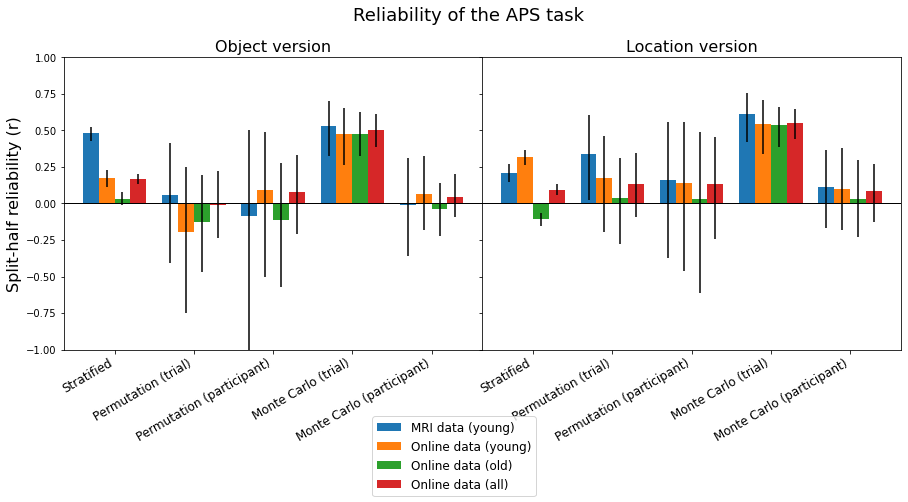

In [302]:
fig, axs = plt.subplots(1, 2, sharey = True, figsize = [15, 7])
fig.suptitle('Reliability of the APS task', fontsize=18)

offset = 0.2
width = 0.2

for i, trial_type, title in zip([0,1], ['OBJ', 'LOC'], ['Object version', 'Location version']):
    df_type = result_df[result_df['trial_type']==trial_type]
    x = np.arange(len(df_type['method'].unique()))

    df_mr_young = df_type[df_type['data_set'] == 'data_mr_young']
    df_online_young = df_type[df_type['data_set'] == 'data_online_young']
    df_online_old = df_type[df_type['data_set'] == 'data_online_old']
    df_online = df_type[df_type['data_set'] == 'data_online']

    axs[i].set_ylim([-1,1])
    axs[i].set_title(title, fontsize=16)
    if i == 0:
        axs[i].set_ylabel('Split-half reliability (r)', fontsize=16)
    axs[i].axhline(0, color='black', linewidth=1)

    mr_young = axs[i].bar(x-offset*1.5, df_mr_young['estimate'], width, yerr=np.array(df_mr_young[['CI_low_diff', 'CI_high_diff']]).T)
    online_young = axs[i].bar(x-offset*0.5, df_online_young['estimate'], width, yerr=np.array(df_online_young[['CI_low_diff', 'CI_high_diff']]).T)
    online_old = axs[i].bar(x+offset*0.5, df_online_old['estimate'], width, yerr=np.array(df_online_old[['CI_low_diff', 'CI_high_diff']]).T)
    online = axs[i].bar(x+offset*1.5, df_online['estimate'], width, yerr=np.array(df_online[['CI_low_diff', 'CI_high_diff']]).T)

    axs[i].set_xticks(x)
    axs[i].set_xticklabels(['Stratified', 'Permutation (trial)', 'Permutation (participant)', 'Monte Carlo (trial)', 'Monte Carlo (participant)'], color = 'black', rotation=0)
    plt.setp(axs[i].get_xticklabels(), rotation = 30, horizontalalignment='right', fontsize=12)

labels_dataset = ['MRI data (young)', 'Online data (young)', 'Online data (old)', 'Online data (all)']
fig.legend(handles=[mr_young, online_young, online_old, online], labels=labels_dataset, loc = 8, fontsize = 'large')
plt.subplots_adjust(wspace=0)
plt.subplots_adjust(bottom=0.3)
plt.savefig(r"C:\Users\user\Documents\GitHub\task-reliability\results\reliability_comparison.png", dpi = 1000, transparent = False, facecolor='white', bbox_inches='tight')
# fig.tight_layout()


In [114]:
from scipy import stats
tips_all = sns.load_dataset("tips")
tips_grouped = tips_all.groupby(["smoker", "size"])
tips = tips_grouped.mean()
tips["CI"] = tips_grouped.total_bill.apply(stats.sem) * 1.96
tips.reset_index(inplace=True)
display(tips)

,smoker,size,total_bill,tip,CI
0,Yes,1,5.825000,1.460000,5.399800
1,Yes,2,17.955758,2.709545,1.805528
2,Yes,3,28.191667,4.095000,6.898186
3,Yes,4,30.609091,3.992727,5.150063
4,Yes,5,29.305000,2.500000,2.263800
5,Yes,6,NaN,NaN,NaN
6,No,1,8.660000,1.415000,2.763600
7,No,2,15.342333,2.489000,0.919042
8,No,3,21.009615,3.069231,2.680447
9,No,4,27.769231,4.195769,3.303131


In [394]:
# Effect sizes
effect_sizes_all = pd.read_csv(r"C:\Users\user\Documents\GitHub\task-reliability\results\Trial level monte carlo\effect_size_summary_trial_montecarlo_1000.csv")
display(effect_sizes_all['data_set'].unique())

# % containing 0
effect_sizes = effect_sizes_all[effect_sizes_all['data_set'] != 'data_online']
effect_sizes_0 = effect_sizes[effect_sizes['d_lower']<=0]
print("Percent of participant CIs containing 0: ", len(effect_sizes_0)/len(effect_sizes)*100, "%")
print("In different samples:")
for data_set in effect_sizes['data_set'].unique():
    df_temp = effect_sizes[effect_sizes['data_set']==data_set]
    df_temp_0 = df_temp[df_temp['d_lower']<=0]
    print("In", data_set, ": ", len(df_temp_0)/len(df_temp)*100, "%")
print("In different task versions:")
for trial_type in effect_sizes['trial_type'].unique():
    df_temp = effect_sizes[effect_sizes['trial_type']==trial_type]
    df_temp_0 = df_temp[df_temp['d_lower']<=0]
    print("In", trial_type, ": ", len(df_temp_0)/len(df_temp)*100, "%")

# Overlap
def percent_overlap(name, data):
    ci = np.array(data[data['online ID']==name][['d_lower', 'd_higher']])[0]
    
    rest = data[data['online ID']!=name][['d_mean', 'd_lower', 'd_higher']]
    rest['CI_overlap'] = np.where((rest['d_lower']>ci[1])|(rest['d_higher']<ci[0]),0,1)
    rest['point_overlap'] = np.where((rest['d_mean']>ci[0])&(rest['d_mean']<ci[1]), 1, 0)

    return(np.sum(rest['CI_overlap'])/len(rest)*100, np.sum(rest['point_overlap'])/len(rest)*100)

overlap_results = pd.DataFrame(columns=['trial_type', 'data_frame', 'CI overlap (%)', 'point estimate overlap (%)'])
for trial_type in effect_sizes_all['trial_type'].unique():
    df_trial_type = effect_sizes_all[effect_sizes_all['trial_type']==trial_type]
    for data_set in effect_sizes_all['data_set'].unique():
        df_temp = df_trial_type[df_trial_type['data_set']==data_set]
        ci_overlap_list = []
        point_overlap_list = []
        for name in df_temp['online ID']:
            ci_overlap, point_overlap = percent_overlap(name, df_temp)
            ci_overlap_list.append(ci_overlap)
            point_overlap_list.append(point_overlap)
        overlap_results.loc[len(overlap_results.index)] = [trial_type, data_set, np.mean(ci_overlap_list), np.mean(point_overlap_list)]

display(overlap_results)
display('Mean Ci overlap', np.mean(overlap_results[overlap_results['data_frame']!='data_online']['CI overlap (%)']), 
'Mean containing point estimate', np.mean(overlap_results[overlap_results['data_frame']!='data_online']['point estimate overlap (%)']))

labels_dataset = {'data_mr_young':'MRI data (young)', 'data_online_young':'Online data (young)', 
                  'data_online_old':'Online data (old)', 'data_online':'Online data (all)'}
version_dict = {'OBJ':'Object version', 'LOC':'Location version'}

overlap_results['data_frame'] = [labels_dataset[name] for name in overlap_results['data_frame']]
overlap_results['trial_type'] = [version_dict[name] for name in overlap_results['trial_type']]
overlap_results.columns = ['Task version', 'Sample', 'CI overlap (average %)', 'Point estimate overlap (average %)']
display(overlap_results.round(2))

array(['data_mr_young', 'data_online_young', 'data_online_old',
       'data_online'], dtype=object)

Percent of participant CIs containing 0:  89.47368421052632 %
In different samples:
In data_mr_young :  84.52380952380952 %
In data_online_young :  81.91489361702128 %
In data_online_old :  96.34146341463415 %
In different task versions:
In OBJ :  90.05847953216374 %
In LOC :  88.88888888888889 %


,trial_type,data_frame,CI overlap (%),point estimate overlap (%)
0,OBJ,data_mr_young,98.838560,79.790941
1,OBJ,data_online_young,99.537465,83.811286
2,OBJ,data_online_old,99.789220,82.821439
3,OBJ,data_online,99.370155,81.474079
4,LOC,data_mr_young,97.328688,70.615563
5,LOC,data_online_young,98.427382,77.983349
6,LOC,data_online_old,97.711533,81.135200
7,LOC,data_online,97.771318,78.258236


'Mean Ci overlap'

98.60547458926958

'Mean containing point estimate'

79.35962970483853

,Task version,Sample,CI overlap (average %),Point estimate overlap (average %)
0,Object version,MRI data (young),98.84,79.79
1,Object version,Online data (young),99.54,83.81
2,Object version,Online data (old),99.79,82.82
3,Object version,Online data (all),99.37,81.47
4,Location version,MRI data (young),97.33,70.62
5,Location version,Online data (young),98.43,77.98
6,Location version,Online data (old),97.71,81.14
7,Location version,Online data (all),97.77,78.26


# Visualize

In [271]:
# Read data
file_end= "_trial_montecarlo_1000"

# result_even_odd = pd.read_csv(r"C:\Users\user\Documents\GitHub\task-reliability\results\even_odd_results.csv")
effect_size_summary = pd.read_csv(r"C:\Users\user\Documents\GitHub\task-reliability\results\Trial level monte carlo\effect_size_summary{0}.csv".format(file_end))
reliability_summary = pd.read_csv(r"C:\Users\user\Documents\GitHub\task-reliability\results\Trial level monte carlo\reliability_summary{0}.csv".format(file_end))
effect_size_distribution = pd.read_csv(r"C:\Users\user\Documents\GitHub\task-reliability\results\Trial level monte carlo\effect_size_distribution{0}.csv".format(file_end))
reliability_distribution = pd.read_csv(r"C:\Users\user\Documents\GitHub\task-reliability\results\Trial level monte carlo\reliability_distribution{0}.csv".format(file_end))


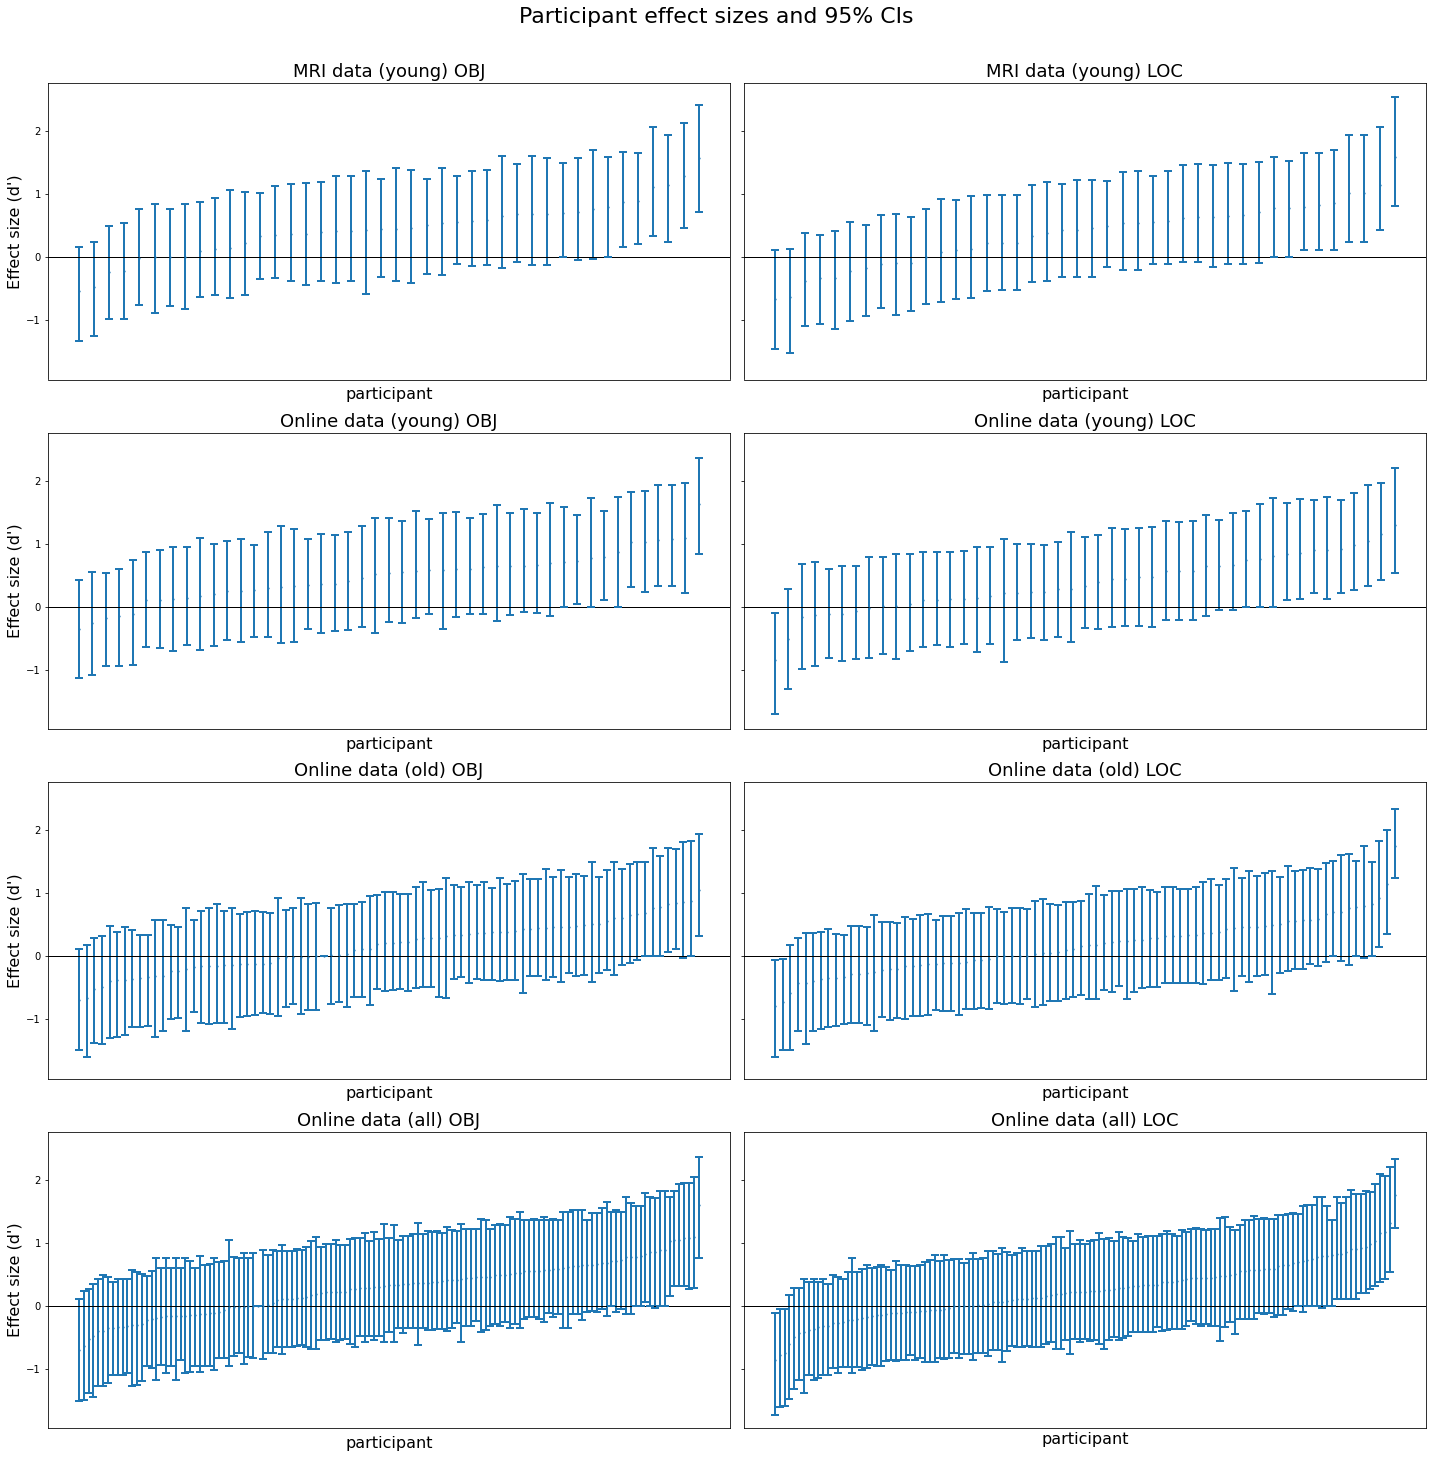

In [337]:
def plot_reliability_dist(distribution, data_set, trial_type, ax):
    """
    Plot the reliability distributions, mean and confidence interval for a given data_set and trial_type.

    Parameters
    ----------
    distribution: array-like
        The distribution of reliability values from the bootstrapping analysis
    data_set: str
        The sample or dataset used for calculation
    trial_type: str
        The condition used for calculation
    ax: matplotlib axis
        Axis to plot onto
    """
    sns.kdeplot(distribution, ax=ax)
    sns.rugplot(distribution, ax=ax)
    ax.set_xlim(0,1)
    ax.axvline(np.mean(distribution), color='orange')
    ax.axvline(np.percentile(distribution,2.5))
    ax.axvline(np.percentile(distribution,97.5))
    ax.set_title(data_set + ' ' + trial_type)
    plt.xlabel('Value of r')

def plot_participant_effects(effect_size_summary, data_set, trial_type, ax, offset, j):
    """
    Plot the participant effects sizes and their 95% CIs for a given data_set and trial_type.

    Parameters
    ----------
    effect_size_summary: dataframe
        Dataframe containing 'online ID', 'd_mean', 'd_lower_diff', d_higher_diff' columns containing participant names, 
        mean effect sizes and their 95% CIs as differences from the mean, respectively
    data_set: str
        The sample or dataset used for calculation
    trial_type: str
        The condition used for calculation
    ax: matplotlib axis
        Axis to plot onto
    offset: float
        Ammount to offset datapoint and errorbars by. Useful for plotting mutltiple points for a participant.
    """
    ax.axhline(0, color='black', linewidth=1)
    ax.errorbar(x=effect_size_summary['online ID'], y=effect_size_summary['d_mean'], yerr=[effect_size_summary['d_lower_diff'],effect_size_summary['d_higher_diff']],\
        marker='o', ls='', capsize=4, capthick=2, elinewidth=2, markersize=1.2)  # +offset
    ax.set_title(labels_dataset[data_set] + ' ' + trial_type, fontsize=18)
    ax.set_xticklabels([])
    ax.tick_params('x', length=0, width=0)
    plt.xticks([]) 
    # plt.xticks(rotation=90)
    ax.set_xlabel('participant', fontsize=16)
    if j == 0:
        ax.set_ylabel("Effect size (d')", fontsize=16)


### Plot into grids ###
file_name_end = 'X'
# Reliability distribution
# fig = plt.figure(figsize=(20,12), tight_layout=True) # Make figure
# fig.suptitle('Distribution of bootstrapped split-half reliability')
# nrows = 2
# ncols = 4
# i = 0

# for trial_type in reliability_distribution['trial_type'].unique():
#     for data_set in reliability_distribution['data_set'].unique():
#         ax = plt.subplot(nrows, ncols, i+1)
#         df_temp = reliability_distribution[(reliability_distribution['data_set']==data_set)&(reliability_distribution['trial_type']==trial_type)]
#         plot_reliability_dist(df_temp['r'], data_set, trial_type, ax=ax)
#         i += 1

# plt.savefig(r"C:\Users\user\Documents\GitHub\task-reliability\reliability_distribution{0}.png".format(file_name_end), dpi = 500, transparent = False, facecolor='white')

# Participant effect sizes
fig, ax = plt.subplots(4, 2, figsize=(20,20), sharey=True) # Make figure
fig.suptitle('Participant effect sizes and 95% CIs', fontsize=22, y=1.01)
nrows = 4
ncols = 2
labels_dataset = {'data_mr_young':'MRI data (young)', 'data_online_young':'Online data (young)', 
                  'data_online_old':'Online data (old)', 'data_online':'Online data (all)'}

for data_set, i in zip(effect_size_summary['data_set'].unique(), [0,1,2,3]):
    for trial_type, j in zip(effect_size_summary['trial_type'].unique(), [0,1]):
        df_temp = effect_size_summary[(effect_size_summary['data_set']==data_set)&(effect_size_summary['trial_type']==trial_type)]
        # df_temp_1 = effect_size_summary_1[(effect_size_summary_1['data_set']==data_set)&(effect_size_summary_1['trial_type']==trial_type)]
        # df_temp_2 = effect_size_summary_2[(effect_size_summary_2['data_set']==data_set)&(effect_size_summary_2['trial_type']==trial_type)]
        df_sorted = df_temp.sort_values('d_mean')
        plot_participant_effects(df_sorted, data_set, trial_type, ax=ax[i,j], offset=0, j=j)
        # plot_participant_effects(df_temp_1, data_set, trial_type, ax=ax, offset=-0.2)
        # plot_participant_effects(df_temp_2, data_set, trial_type, ax=ax, offset=0.2)


plt.tight_layout()

plt.savefig(r"C:\Users\user\Documents\GitHub\task-reliability\results\participant_effect_sizes.png", dpi = 500, transparent = False, facecolor='white', bbox_inches='tight')


,Unnamed: 0,online ID,d_mean,d_lower,d_higher,d_lower_diff,d_higher_diff,data_set,trial_type,ID_num
0,0,101mTRK21M,0.440581,-0.420857,1.348980,0.861438,0.908399,data_mr_young,OBJ,0.0
1,1,102mTRK21M,0.134072,-0.756993,0.967422,0.891065,0.833350,data_mr_young,OBJ,1.0
2,2,106mTRK22F,0.404143,-0.292932,1.300937,0.697075,0.896794,data_mr_young,OBJ,2.0
3,3,10mTRK23F,-0.230547,-0.967422,0.464061,0.736875,0.694608,data_mr_young,OBJ,3.0
4,4,112mTRK22F,1.475303,0.756993,2.162392,0.718310,0.687089,data_mr_young,OBJ,4.0


,Unnamed: 0,online ID,d_mean,d_lower,d_higher,d_lower_diff,d_higher_diff,data_set,trial_type,ID_num
477,6,1069Y2142F,-0.849983,-1.731664,0.000000,0.881682,0.849983,data_online,LOC,6.0
135,4,1069Y2142F,-0.847600,-1.641911,0.000000,0.794311,0.847600,data_online_young,LOC,4.0
267,7,1150234F,-0.780394,-1.641911,0.000000,0.861517,0.780394,data_online_old,LOC,7.0
491,20,1150234F,-0.779435,-1.593423,-0.113737,0.813988,0.665698,data_online,LOC,20.0
304,44,50501014M,-0.742229,-1.593423,0.000000,0.851193,0.742229,data_online_old,LOC,44.0


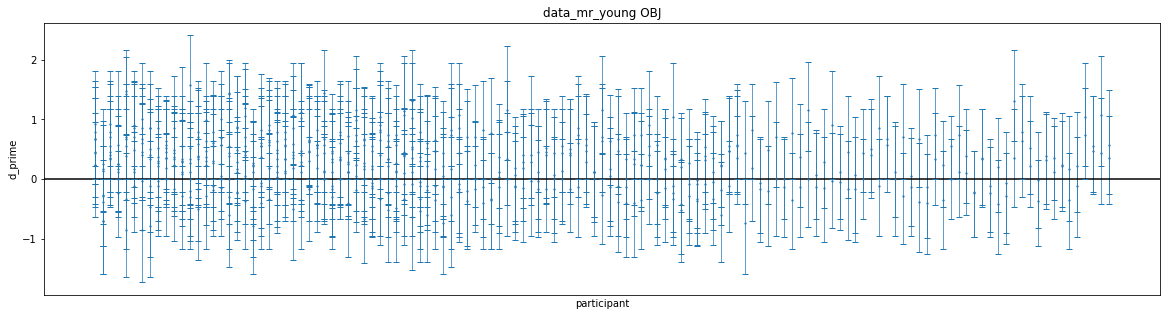

In [267]:
display(effect_size_summary.head())
df_sorted = effect_size_summary.sort_values('d_mean')
display(df_sorted.head())
fig, ax = plt.subplots(1,1, figsize=(20,5))
plot_participant_effects(df_sorted, 'data_mr_young', 'OBJ', ax=ax, offset=0)

In [9]:
### Other visualization options ###

# sns.displot(data=effect_sizes, x='d_prime', hue='online ID', kind='kde')
# plt.show()
# fig, ax = plt.subplots(figsize=(25,10))
# sns.violinplot(data=effect_sizes, x="online ID", y="d_prime", ax=ax)
# ax.axhline(0, color='black')
# plt.xticks(rotation=90)
# plt.show()
# fig, ax = plt.subplots(figsize=(25,10))
# sns.boxplot(data=effect_sizes, x="online ID", y="d_prime", ax=ax)
# ax.axhline(0, color='black')
# plt.xticks(rotation=90)
# plt.show()
# sns.boxplot(data=effect_sizes, x="online ID", y="d_prime", ax=ax)
# sns.violinplot(data=effect_sizes, x="online ID", y="d_prime", ax=ax)
# sns.stripplot(data=effect_sizes, x="online ID", y="d_prime", ax=ax)

In [35]:
def compare_dprimes(data, participant, e_o=None):
    # Regression to calculate d-prime
    data_participant = data[data['online ID']==participant][['online ID', 'StimType', 'ResponseNew', 'trial_num']]  # , 'trial_num'

    ## Subtraction
    # Calculate proportion of old-target answers to all answers and old-lure answers to all answers
    all_target = len(data_participant[data_participant['StimType']=='TARGET'])
    all_lure = len(data_participant[data_participant['StimType']=='LURE'])
    p_old_target = len(data_participant[(data_participant['ResponseNew']==0) & (data_participant['StimType']=='TARGET')]) / all_target
    p_old_lure = len(data_participant[(data_participant['ResponseNew']==0) & (data_participant['StimType']=='LURE')]) / all_lure

    # Avoiding infinite values by edge-correction
    p_old_target = edge_correction(p_old_target, all_target)
    p_old_lure = edge_correction(p_old_lure, all_lure)

    # Calculate d-prime
    discrimination = stats.norm.ppf(p_old_target) - stats.norm.ppf(p_old_lure)
    discrimination_raw = p_old_target - p_old_lure

    # Calculate d-prime with regression
    data_participant = data_participant[(data_participant['StimType']=='TARGET')|(data_participant['StimType']=='LURE')]
    recode_dict = {'LURE':1, 'TARGET': 0}
    data_participant.loc[:,'StimTypeNum'] = [recode_dict[data_participant.loc[i, 'StimType']] for i in data_participant.index]
    data_participant.loc[:, 'ResponseOld'] = abs(data_participant['ResponseNew']-1)

    result = sm.regression.linear_model.OLS(data_participant['ResponseOld'], sm.add_constant(data_participant[['StimTypeNum', 'trial_num']])).fit()

    reg_0 = edge_correction(float(result.params[0]), all_target)
    reg_01 = edge_correction(float(result.params[0] + result.params[1]), all_lure)
    # reg_0 = result.params[0]
    # reg_01 = result.params[0] + result.params[1]
    reg_dprime = stats.norm.ppf(reg_0) - stats.norm.ppf(reg_01)

    return(discrimination, discrimination_raw, reg_dprime, result.params[1], result.params[0],
           result.params[0] + result.params[1], p_old_lure, p_old_target,
           1-np.mean(data_participant[data_participant['StimType']=='LURE']['ResponseNew']), 
           1-np.mean(data_participant[data_participant['StimType']=='TARGET']['ResponseNew']))


data = data_list[1][data_list[1]['TrialType']=='OBJ']
# data = data_mr_young[data_mr_young['TrialType']=='OBJ']
data_even, data_odd, data = assign_even_odd(data, 'online ID')

dprimes_2_dif = discrimination_calculator(data, method='difference', filters=None)
dprimes_2_reg = discrimination_calculator(data, method='regression', filters=None)

dprimes_even = pd.DataFrame(columns=['dprime_z', 'dprime_raw', 'reg_dprime', 'slope', 'const', 'const_slope_sum', 'p_old_lure', 'p_old_target',
                                'mean_lure', 'mean_target'])
dprimes_odd = pd.DataFrame(columns=['dprime_z', 'dprime_raw', 'reg_dprime', 'slope', 'const', 'const_slope_sum', 'p_old_lure', 'p_old_target',
                                'mean_lure', 'mean_target'])
dprimes = pd.DataFrame(columns=['dprime_z', 'dprime_raw', 'reg_dprime', 'slope', 'const', 'const_slope_sum', 'p_old_lure', 'p_old_target',
                                'mean_lure', 'mean_target'])

for participant in data['online ID'].unique():
    dprimes_even.loc[len(dprimes_even.index)] = compare_dprimes(data_even, participant, e_o='even')
    dprimes_odd.loc[len(dprimes_odd.index)] = compare_dprimes(data_odd, participant, e_o='odd')
    dprimes.loc[len(dprimes.index)] = compare_dprimes(data, participant, e_o='odd')

display(dprimes)  # dprimes_even, dprimes_odd,

C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\pandas\core\indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\pandas\core\indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


,dprime_z,dprime_raw,reg_dprime,slope,const,const_slope_sum,p_old_lure,p_old_target,mean_lure,mean_target
0,0.749367,0.291667,0.772205,-0.289905,0.745957,0.456052,0.375000,0.666667,0.375000,0.666667
1,0.243762,0.083333,0.220184,-0.087612,0.557480,0.469868,0.666667,0.750000,0.666667,0.750000
2,0.674490,0.250000,0.707175,-0.249028,0.793761,0.544734,0.500000,0.750000,0.500000,0.750000
3,0.105795,0.041667,0.101267,-0.040378,0.514156,0.473778,0.416667,0.458333,0.416667,0.458333
4,0.641156,0.250000,0.671882,-0.251576,0.512420,0.260844,0.333333,0.583333,0.333333,0.583333
5,0.831710,0.250000,1.141262,-0.248252,0.953640,0.705388,0.625000,0.875000,0.625000,0.875000
6,1.057175,0.208333,0.652379,-0.210771,0.831251,0.620479,0.750000,0.958333,0.750000,0.958333
7,0.326094,0.125000,0.385431,-0.121864,0.807771,0.685907,0.541667,0.666667,0.541667,0.666667
8,0.292932,0.083333,0.224403,-0.089072,0.575099,0.486027,0.750000,0.833333,0.750000,0.833333
9,0.570776,0.125000,0.666078,-0.124435,0.942086,0.817651,0.791667,0.916667,0.791667,0.916667


In [29]:
print(stats.norm.ppf(1.0000000000000002))
print(stats.norm.ppf(0.541667))
print(stats.norm.ppf(0.375000))
print(stats.norm.ppf(0.541667) - stats.norm.ppf(0.375000))
reg_0 = edge_correction(0.541667, 24)
print(reg_0)


nan
0.10463429574324004
-0.31863936396437514
0.4232736597076152
0.9791666666666666


In [ ]:
def bootstrapping_loop_v2(data, n, id_var='online ID', nonparametric=False):
    # TODO doesn't work, is it faster?
    data_1, data_2 = pd.DataFrame(columns=data.columns), pd.DataFrame(columns=data.columns)
    for participant in data[id_var].unique():
        data_participant = data[data[id_var] == participant]
        data_1_target = data_participant[data_participant['StimType']=='TARGET'].sample(frac=n, replace=True)
        data_1_lure = data_participant[data_participant['StimType']=='LURE'].sample(frac=n, replace=True)
        data_1 = pd.concat([data_1, data_1_target, data_1_lure])
        data_2_target = data_participant[data_participant['StimType']=='TARGET'].sample(frac=n, replace=True)
        data_2_lure = data_participant[data_participant['StimType']=='LURE'].sample(frac=n, replace=True)
        data_2 = pd.concat([data_2, data_2_target, data_2_lure])

    resample_nums = []
    for i in range(0,n):
        resample_nums = resample_nums + [str(i)]*len(data[(data['StimType']=='TARGET')|(data['StimType']=='LURE')])
    data_1['resample_num'] = resample_nums
    data_2['resample_num'] = resample_nums

    effect_sizes = pd.DataFrame()
    reliability_distribution = []
    # Calculating participant effect sizes
    for i in resample_nums:
        data_1_temp, data_2_temp = data_1[data_1['resample_num']==i], data_2[data_2['resample_num']==i]
        discrimination_1 = discrimination_calculator(data_1_temp)
        discrimination_2 = discrimination_calculator(data_2_temp)
        discrimination = pd.concat([effect_sizes, discrimination_1, discrimination_2])

        # Calculating split-half reliability with Pearson or Spearman
        if nonparametric:
            reliability = stats.spearmanr(discrimination_1['d_prime'], discrimination_2['d_prime']).correlation
        else:
            reliability = np.corrcoef(discrimination_1['d_prime'], discrimination_2['d_prime'])[0][1]
        reliability_distribution.append(reliability)
    return reliability_distribution, effect_sizes


In [1]:
import this

The Zen of Python, by Tim Peters

Beautiful is better than ugly.
Explicit is better than implicit.
Simple is better than complex.
Complex is better than complicated.
Flat is better than nested.
Sparse is better than dense.
Readability counts.
Special cases aren't special enough to break the rules.
Although practicality beats purity.
Errors should never pass silently.
Unless explicitly silenced.
In the face of ambiguity, refuse the temptation to guess.
There should be one-- and preferably only one --obvious way to do it.
Although that way may not be obvious at first unless you're Dutch.
Now is better than never.
Although never is often better than *right* now.
If the implementation is hard to explain, it's a bad idea.
If the implementation is easy to explain, it may be a good idea.
Namespaces are one honking great idea -- let's do more of those!
